<a href="https://colab.research.google.com/github/wurDevTim/Workshop_P4P/blob/main/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welkom to the P4P workshop!
This notebook gives a few examples on how to analyse cropreporter data with plantcv. There are also various tutorials on the plantcv website, unfortunately they are not all updated to plantcv v4.0: https://plantcv.readthedocs.io/en/stable/tutorials/







# Preperation
For this training we prepared a small dataset you can use, please download it from:
https://drive.google.com/file/d/1qaFPIgGrOB_t1xNH8wub1LzzmV8uvSZG/view?usp=sharing

Unzip the folder and upload the content to your own  google drive.
Using the folder icon on the left side of the screen you can mount your own google drive to access the data from google colab

In [1]:
# Plantcv only suports python version 3.8, 3.9 and 3.10.
# Colab only supports one python version, the current version is 3.10.12
import sys
print(f"Running python version: {sys.version}")

Running python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


Install the requirements

In [2]:
# plantcv requires a newer version of altair than installed by default
!pip install altair==5.0.1
!pip install plantcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.9/327.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 52.5 MB/s eta 0:00:00


In [3]:
# Check if the data folder is mounted correctly
datafolder = "/content/drive/My Drive/npec_tomato"
!ls "$datafolder"

20231018_AO1  20231018_AO10  20231018_AO11  20231018_AO12  20231018_AO13


In [4]:
# Importing Libraries
from google.colab.patches import cv2_imshow
# Import packages
from plantcv import plantcv as pcv
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [25]:
print(f"Currently installed plantcv version is v{pcv.__version__}")

Currently installed plantcv version is v4.0.1


# Plantcv
Plantcv implements quite some functions, in the notebook examples are gives of how to load the data and:
- Use the Chlorophyll image to create a mask
- Compute the spectral indicies
- compute the FV/FM
- Analyse an entire folder automatically

For more information see:
https://plantcv.readthedocs.io/en/stable/photosynthesis_read_cropreporter/

In [20]:
# Configure plantcv to show debug output
pcv.params.debug = "plot"
pcv.params.debug_outdir = "temp_output"
outdir = 'temp_output'

# Plantcv photosynthesis object
To start using plantcv for analysis of cropreporter data the following function can be called with the `.inf` file:

```
pcv.photosynthesis.read_cropreporter
```
The function automatically checks the folder for other cropreporter files like the SPC, PML, PMD, CHL and CLR file.

The function returns a PSII_data instance, which contains a subclass per data object:
*   ojip_light
*   ojip_dark
*   pam_light
*   pam_dark
*   chlorophyll
*   spectral

The RGB data is collected with the same monochrome camera as the spectral data, the only difference is the filter that is used: a Red, green or Blue filter.
It can be accesed with: `ps.spectral.pseudo_rgb`.




Compiling: CHL
Compiling: CLR
Compiling: SPC


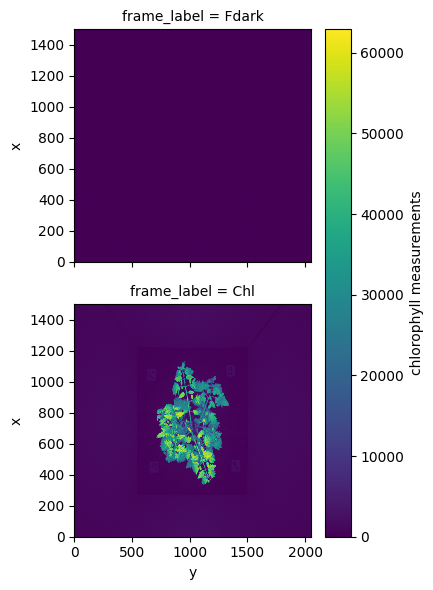

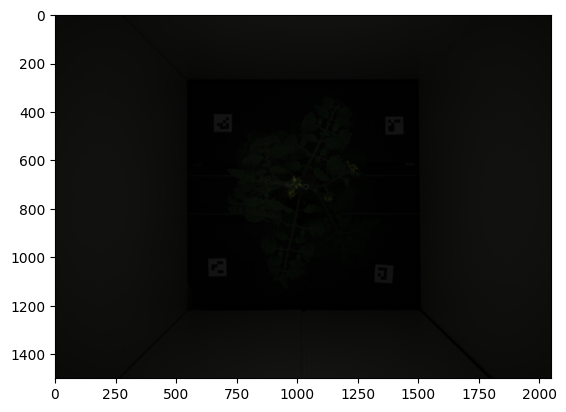

In [21]:
# Load the first dataset into plantcv
filename = datafolder + "/20231018_AO1/HDR_96_NPEC51.20230906.AO1.MoneyMaker.Salt.88_1476.INF"
ps = pcv.photosynthesis.read_cropreporter(filename=filename)

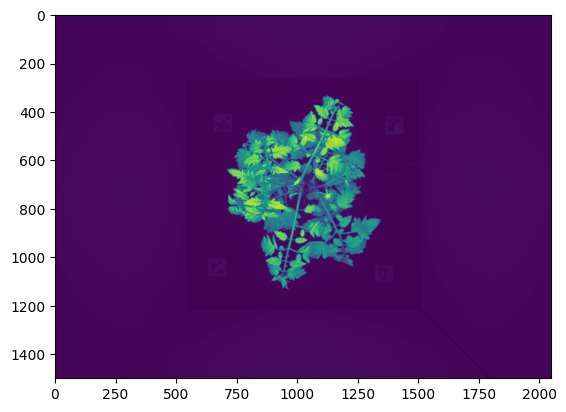

In [8]:
# Show the chlorophyll image
chlorophyll = ps.chlorophyll.sel(frame_label='Chl').to_numpy()
plt.imshow(chlorophyll)

In [9]:
# Note the big difference between the plant and background.
# this makes the chlorophyll ideall to create masks
mask = pcv.threshold.otsu(gray_img=img_as_ubyte(ps.chlorophyll.sel(frame_label="Chl").data), object_type="light")
#mask = pcv.fill_holes(bin_img=mask)

In [31]:
# Compute average chlorophyll
chlorophyll = ps.chlorophyll.sel(frame_label='Chl').to_numpy()
masked_chlorophyll = cv2.bitwise_and(chlorophyll, chlorophyll, mask=mask)
mean_chlorophyll = np.nanmean(chlorophyll[mask > 0])
print(f"average chlorophyll: {round(mean_chlorophyll, 2)}")

average chlorophyll: 34901.0


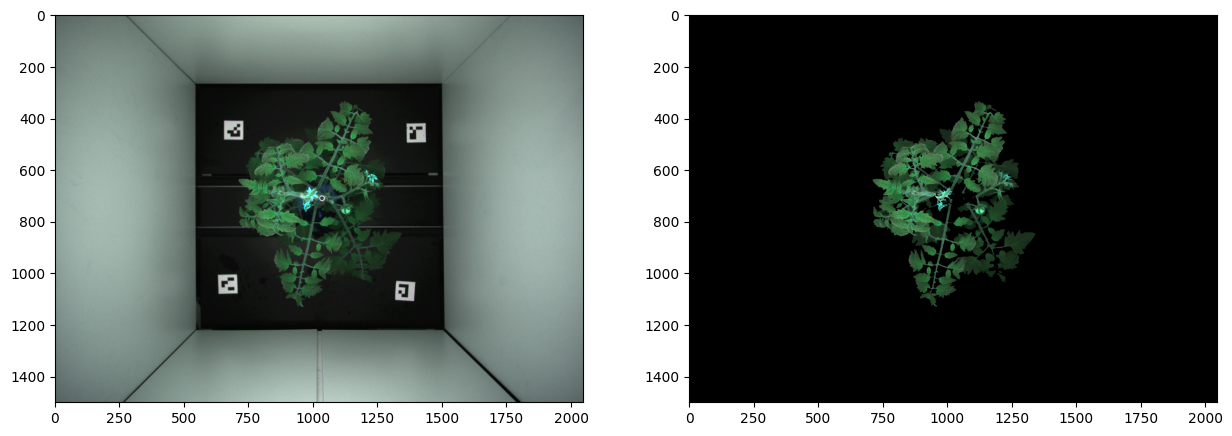

In [10]:
# Show the RGB image
img = ps.spectral.pseudo_rgb
img = cv2.bitwise_and(img, img, mask=mask)
# first parameter is the contract scaling, the second the brightness, which is increased slightly for vizualisation
# For a concrete example see: https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python
img = cv2.convertScaleAbs(img, 1.0, 10)

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(cv2.convertScaleAbs(ps.spectral.pseudo_rgb, 1.0, 10))
axarr[1].imshow(img)
plt.show()
# Left the original image, Right the masked image

It is challenging to find a solution that scales to all plant species.
Here will show a few corrections you can apply, try to find some others and think of a different way to compare the different masks

In [11]:
# Fill small objects to remove noise and get a complete plant
# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.
filled_mask = pcv.fill(bin_img=mask, size=200)

In [12]:
# Erode a small border of pixels from the mask
# Inputs:
#   gray_img - Grayscale (usually binary) image data
#   ksize - The size used to build a ksize x ksize
#            matrix using np.ones. Must be greater than 1 to have an effect
#   i - An integer for the number of iterations
eroded_mask = pcv.erode(gray_img=mask, ksize=3, i=1)

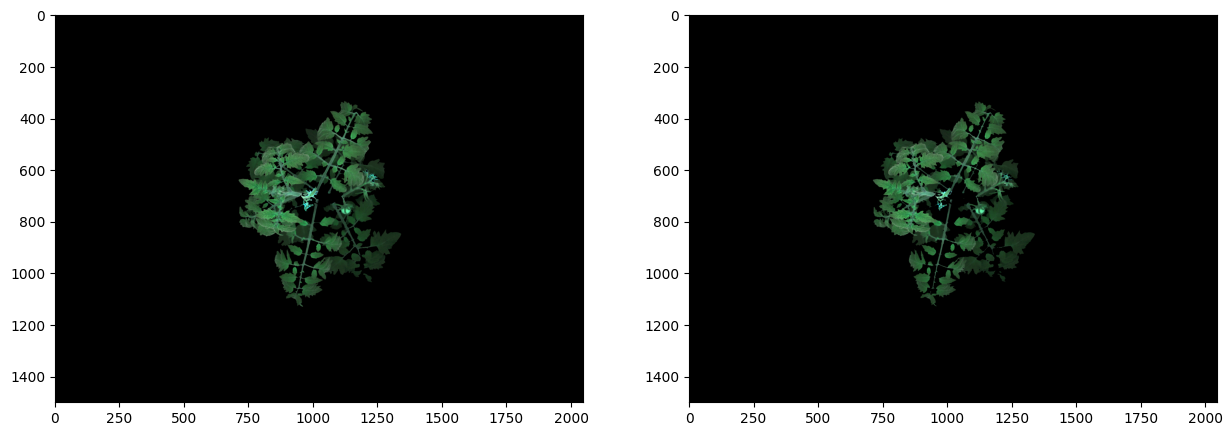

In [ ]:
unmasked_rgb = cv2.convertScaleAbs(ps.spectral.pseudo_rgb, 1.0, 10)
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(cv2.bitwise_and(unmasked_rgb, unmasked_rgb, mask=filled_mask))
axarr[1].imshow(cv2.bitwise_and(unmasked_rgb, unmasked_rgb, mask=eroded_mask))
plt.show()

In [ ]:
# One way to compare masks on similairy is to calculate the intersection over union.
# It returns values between 0-1, where 1 is identical and zero shows no overlap.
def calculate_iou(maska, maskb):
  maska = maska.flatten()
  maskb = maskb.flatten()
  mask = np.zeros_like(maska)
  mask[maska > 0] = 1
  mask_two = np.zeros_like(maskb)
  mask_two[maskb > 0] = 1

  overlap = mask * mask_two  # Logical AND
  union = (mask + mask_two)>0  # Logical OR
  iou = overlap.sum() / float(union.sum())
  return iou

print(f"Similairy of the original mask and filled mask: {round(calculate_iou(mask, filled_mask), 3)}, similairy of the erorded and original mask: {round(calculate_iou(mask, eroded_mask), 3)}")

Similairy of the original mask and filled mask: 0.999, similairy of the erorded and original mask: 0.898


# Spectral indices
Different pigments and chlorophyll content can be meassured at different wavelengths, by combining these meassurements something can be said about the relation. As an example NDVI looks at changes in the chlorophyl absorption of the plant.
A lower value indicates somethings is wrong with the plant, but it does not say anything about the cause.
It is also important to note that:
- Each camera uses slightly different settings/configurations which result in different NDVI values, making it challenging to compare or exactly reproduce experiments.
- Plants grow towards the camera, as they come closer there is less dispersion of light which is no problem when you fly 30 meters aboven a potato field but introduces bias in meassurement taken upclose as done by the cropreporter.

There is an extensive list of spectral indexes available in plantcv, however not all can be computer with the wavelengths meassured with the cropreporter and also not all are tested in the field:
https://github.com/danforthcenter/plantcv/blob/main/plantcv/plantcv/spectral_index/spectral_index.py

The indexes we show here are chosen based on this study:
[Application of Phenotyping Methods in Detection of Drought and Salinity Stress in Basil (Ocimum basilicum L.) (Boris et al. 2021)](https://www.frontiersin.org/articles/10.3389/fpls.2021.629441/full)
- NDVI
- ARI
- PSRI
- Egreen

## Wavelengths
A few weeks ago we discovered a small bug in the plantcv code, which is described here [cropreporter wavelengths](https://github.com/danforthcenter/plantcv/issues/1373)
This is fixed in the main branch, as there is no new release yet we are currently using a plantcv version which contains this bug.

Currently the wavelengths are: {460, 500, 550, 670, 700, 800}
this be checked by running: `ps.spectral.wavelength_dict`

The wavelengths of the NPEC cropreporter are in reality: {475, 540, 550, 640, 710, 770}
Unfortunately phenovation does not store this in their metadata so we cannot guaranty that this is the same for all systems sold worldwide.




In [27]:
#In the fix below we asume the dataset contains both a CLR and SPC file.
ps.spectral.wavelength_dict

{460: 0.0, 500: 1.0, 550: 2.0, 670: 3.0, 700: 4.0, 800: 5.0}

In [29]:
# Overwrite the dictionary with the correct wavelengths
ps.spectral.wavelength_dict = {475: 0.0, 540: 1.0, 550: 2.0, 640: 3.0, 710: 4.0, 770: 5.0}

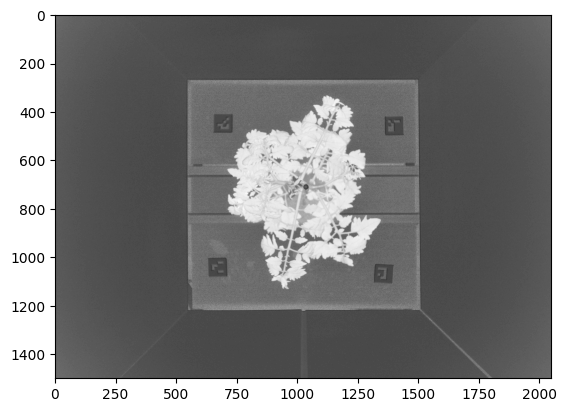

ndvi: 0.7955663204193115


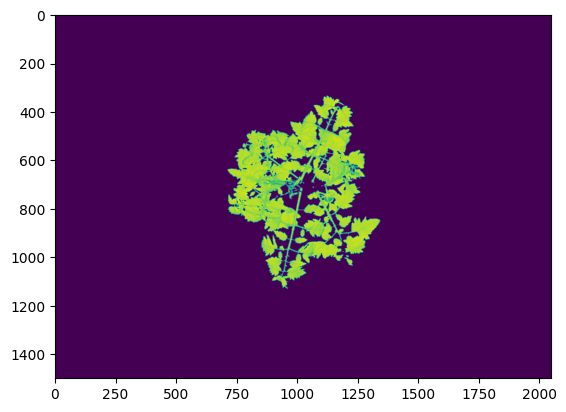

In [15]:
# Normalized Difference Vegetation Index: (R800 - R670) / (R800 + R670)
# The theoretical range for NDVI is [-1.0, 1.0]
ndvi_img = pcv.spectral_index.ndvi(hsi=ps.spectral).array_data
masked_ndvi_img = cv2.bitwise_and(ndvi_img, ndvi_img, mask=mask)
mean_ndvi = np.nanmean(ndvi_img[mask > 0])
print(f"ndvi: {mean_ndvi}")
plt.imshow(masked_ndvi_img)

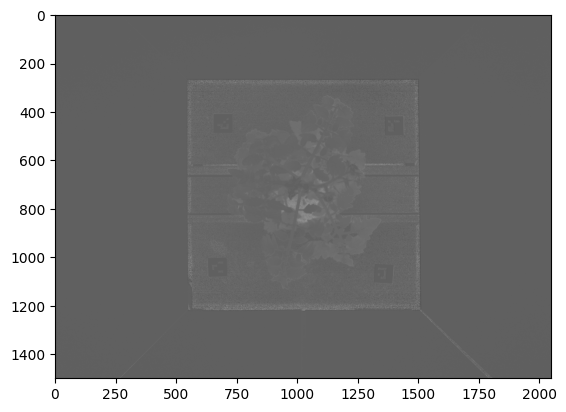

ari: 17.602664947509766


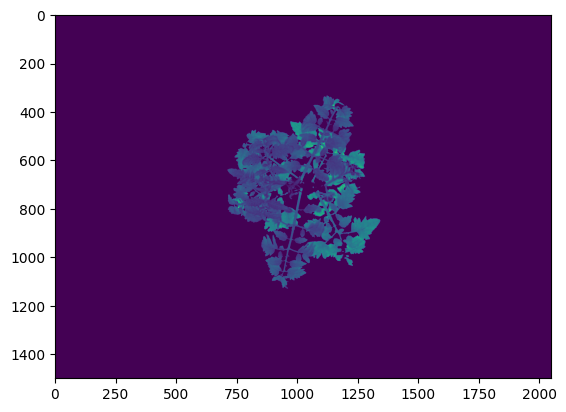

In [16]:
# Anthocyanin Reflectance Index: (1 / R550) - (1 / R700)
# The theoretical range for ARI is (-Inf, Inf)
ari_img = pcv.spectral_index.ari(hsi=ps.spectral).array_data
masked_ari_img = cv2.bitwise_and(ari_img, ari_img, mask=mask)
plt.imshow(masked_ari_img)
mean_ari = np.nanmean(ari_img[mask > 0])
print(f"ari: {mean_ari}")

modified ari: 3.329653024673462


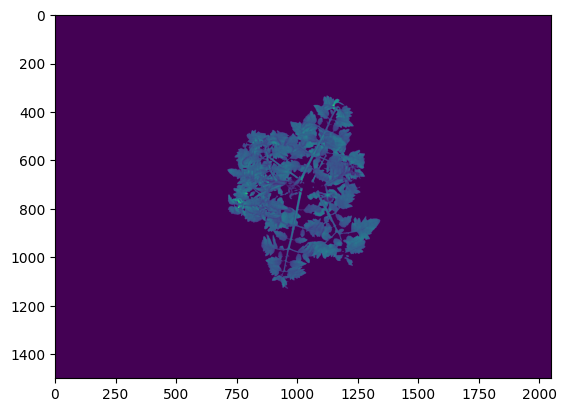

In [14]:
# Modified Anthocyanin Reflectance Index: ((1 / R550) - (1 / R700)) * R800
# The theoretical range for Modified ARI is (-Inf, Inf)
mari_img = pcv.spectral_index.mari(hsi=ps.spectral).array_data
masked_mari_img = cv2.bitwise_and(mari_img, mari_img, mask=mask)
plt.imshow(masked_mari_img)
mean_mari = np.nanmean(mari_img[mask > 0])
print(f"modified ari: {mean_mari}")

In [15]:
ps.spectral.wavelength_dict

{460: 0.0, 500: 1.0, 550: 2.0, 670: 3.0, 700: 4.0, 800: 5.0}

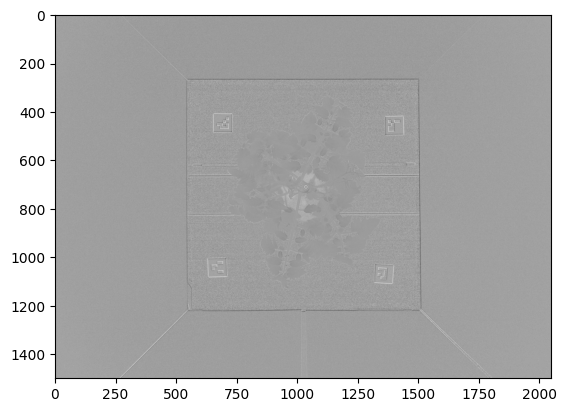

psri: -0.0634971335530281


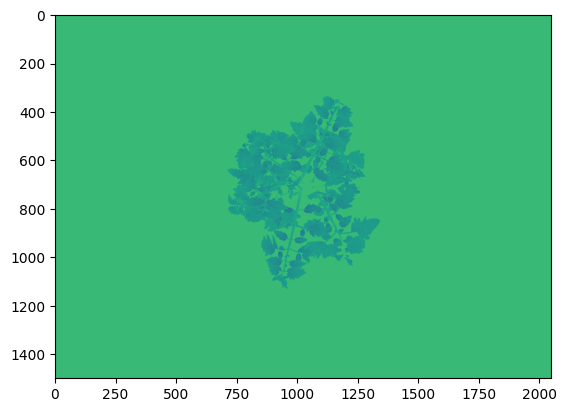

In [14]:
# Plant Senescence Reflectance Index: (R678 - R500) / R750
# The theoretical range for PSRI is (-Inf, Inf)
# An increase in PSRI sugest an increase in canopy stress.
psri_img = pcv.spectral_index.psri(hsi=ps.spectral).array_data
masked_psri_img = cv2.bitwise_and(psri_img, psri_img, mask=mask)
plt.imshow(masked_psri_img)
mean_psri = np.nanmean(psri_img[mask > 0])
print(f"psri: {mean_psri}")

/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:270: RuntimeWarning: invalid value encountered in divide
  r = red.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:271: RuntimeWarning: invalid value encountered in divide
  g = green.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:272: RuntimeWarning: invalid value encountered in divide
  b = blue.astype(np.float32) / total


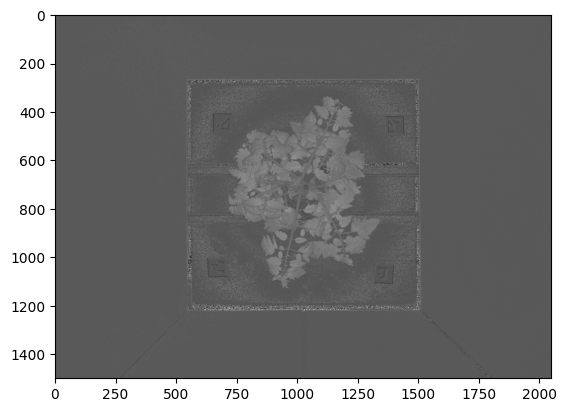

egreen: 0.4103858470916748


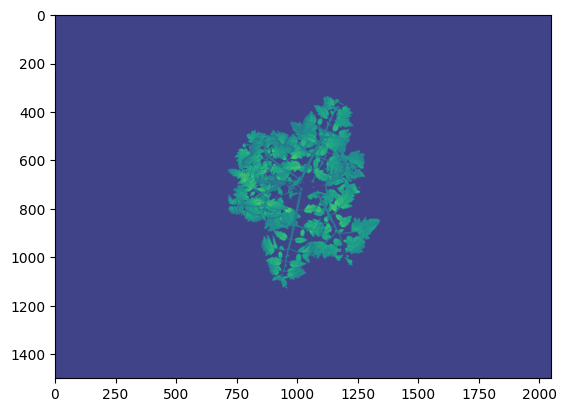

In [17]:
# Excess Green Index: 2g - r - b
# The theoretical range for EGI is (-1, 2)
# Question why do you see warnings?
egreen_img = pcv.spectral_index.egi(ps.spectral.pseudo_rgb).array_data
masked_egreen_img = cv2.bitwise_and(egreen_img, egreen_img, mask=mask)
plt.imshow(masked_egreen_img)
mean_egreen = np.nanmean(egreen_img[mask > 0])
print(f"egreen: {mean_egreen}")

# Which other indexes you think will be interesting to analyse? Why?
To give you a hint, our cropreporter meassures at the following wavelengths:
- [RGB wavelengths](https://github.com/danforthcenter/plantcv/blob/10a33cc8cdba9c7a5f8dda0637e4172cbf6681b5/plantcv/plantcv/photosynthesis/read_cropreporter.py#L282C9-L282C21)
- [Spectral wavelengths](https://github.com/danforthcenter/plantcv/blob/10a33cc8cdba9c7a5f8dda0637e4172cbf6681b5/plantcv/plantcv/photosynthesis/read_cropreporter.py#L289C14-L289C14)


#Photosynthesis analysis
Unfortunately there is no consesus on how photosythesis meassurement should be done or how to name the frames, as a result different terms are used in literature. For the cropreporter PAM meassurements it is as follows in plantcv.

PAM light:
- **Flightt** Correction frame (actinic light on)
- **Fp** Fluorescence level light adapted plant of averaged measurement pulses,
already corrected for Flightt
- **Fmp** Fluorescence level during saturation around 0.8s of averaged measurement pulses,
already corrected for Fs
- **Fs** Correction frame (actinic light and saturation light on)

PAM dark:
- **Fdark** Correction frame (no light)
- **F0** Fluorescence level dark adapted plant of averaged measurement pulses,
already corrected for Fdark
- **Fm** Fluorescence level during saturation around 0.8s of averaged measurement pulses,
 already corrected for Fs
- **Fs** Correction frame (saturation light on)

We can compute the Fp/Fmp or F0/Fm, also known as Fv/Fm and Fq'/Fm'.
The raw meassurements (Fm+Fs) are not stored and cannot be used for analysis

In [ ]:
# In our meassurements we ofter see zero Fm values for plant pixels.
# Therefore we implemented this data quality check: How many pixels in the Fm/Fmp image are zero?
FM = None
if not ps.pam_dark is None:
  #Extract FM data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fm').to_numpy()
elif not ps.pam_light is None:
  #Extract FMp data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fmp').to_numpy()

if not FM is None:
  output = np.full(FM.shape, np.nan)
  output[mask > 0] = FM[mask > 0]
  output = output.flatten()
  print(f"{len(output[output == 0])} of the {len(output)} pixels, {int(len(output[output == 0])/len(output)*100)}% in the FM image are zero")

In [ ]:
# Calculate and analyze PSII efficiency
if not ps.pam_dark is None:
  yii_global, yii_chart = pcv.analyze.yii(ps_da=ps.pam_dark, labeled_mask=mask, measurement_labels=["Fv/Fm"])
elif not ps.pam_light is None:
  yii_global, yii_chart = pcv.analyze.yii(ps_da=ps.pam_light, labeled_mask=mask, measurement_labels=["Fq'/Fm'"])

stats = {'min_yii': float(yii_global.min().values), 'mean_yii': float(yii_global.mean().values), 'max_yii': float(yii_global.max().values)}
stats

# Questions
- Can you think of more quality checks to perform on the data?
- Which other parameters can you compute from this data?

# Example to process an dataset
This notebook gives examples aof what can be done with plantcv using a single plant.
Once you hav found the parameters you want to analyse you might want to analyse all the data of an entire experiment. In this section an example workflow is given:

In [ ]:
# Perperation
from glob import glob
import pandas as pd
pcv.params.debug = "None"

In [ ]:
all_parameters_list = []
# Loop over all plants
for filename in glob(datafolder + "/**/*.INF"):
  # Load data
  print(f'analyzing: {filename}')
  a_ps = pcv.photosynthesis.read_cropreporter(filename=filename)
  # Mask
  mask = pcv.threshold.otsu(gray_img=img_as_ubyte(ps.chlorophyll.sel(frame_label="Chl").data), object_type="light")
  mask = cv2.flip(mask, 0)

  # Correct wavelengths
  ps.spectral.wavelength_dict = {475: 0.0, 540: 1.0, 550: 2.0, 640: 3.0, 710: 4.0, 770: 5.0}

  # NDVI
  ndvi_img = pcv.spectral_index.ndvi(hsi=ps.spectral).array_data
  masked_ndvi_img = cv2.bitwise_and(ndvi_img, ndvi_img, mask=mask)
  mean_ndvi = round(np.nanmean(ndvi_img[mask > 0]),2)
  # Optional add other traits
  #....

  #....
  # Createdictionary with plant parameters
  plant_parameters = {'filename': filename,
                      'mean_ndvi': mean_ndvi
                      }
  all_parameters_list.append(plant_parameters)

analyzing: /content/drive/My Drive/npec_tomato/20231018_AO11/HDR_96_NPEC51.20230906.AO11.MoneyMaker.Salt.93_1476.INF
Compiling: CHL
Compiling: CLR
Compiling: SPC
analyzing: /content/drive/My Drive/npec_tomato/20231018_AO12/HDR_96_NPEC51.20230906.AO12.MoneyMaker.Control.94_1476.INF
Compiling: CHL
Compiling: CLR
Compiling: SPC
analyzing: /content/drive/My Drive/npec_tomato/20231018_AO10/HDR_96_NPEC51.20230906.AO10.MoneyMaker.Control.93_1476.INF
Compiling: CHL
Compiling: CLR
Compiling: SPC
analyzing: /content/drive/My Drive/npec_tomato/20231018_AO13/HDR_96_NPEC51.20230906.AO13.MoneyMaker.Salt.94_1476.INF
Compiling: CHL
Compiling: CLR
Compiling: SPC
analyzing: /content/drive/My Drive/npec_tomato/20231018_AO1/HDR_96_NPEC51.20230906.AO1.MoneyMaker.Salt.88_1476.INF
Compiling: CHL
Compiling: CLR
Compiling: SPC


In [ ]:
# Combine all dictionaries into one table
parameter_table = pd.DataFrame(all_parameters_list)
parameter_table

,filename,mean_ndvi
0,/content/drive/My Drive/npec_tomato/20231018_A...,0.617214
1,/content/drive/My Drive/npec_tomato/20231018_A...,0.617214
2,/content/drive/My Drive/npec_tomato/20231018_A...,0.617214
3,/content/drive/My Drive/npec_tomato/20231018_A...,0.617214
4,/content/drive/My Drive/npec_tomato/20231018_A...,0.617214


In [ ]:
# Save table as csv
parameter_table.to_csv('cropreporter_traits.csv', index = False)